<a href="https://colab.research.google.com/github/FredLongo/MLDL_Project/blob/main/TeamProject_V2024_04_09_01_MSI_P3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Review with Video https://www.youtube.com/watch?v=hpfQE0bTeA4

Done
* Correct Nodes lableing
* Auto Model Layers by parameter


TODO updates.
* Auto Nodes by input Parameter Size
* Use Kaggle Data.
* Only Pull Data with change in Ticker
* graph each stock



#Code Section

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
pip install pandas_ta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 1.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218907 sha256=6d8d30a7fb2f312a8e581f822d596e305f2aa70f6f0950e4449daa8a6c1c762a
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas_ta


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import pandas_ta as ta
from sklearn.preprocessing import MinMaxScaler
import warnings
from datetime import datetime, timedelta


"""#Now build the model"""
from re import VERBOSE
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import TimeDistributed

import tensorflow as tf
import keras
from keras import optimizers
from keras.callbacks import History
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate

""" performance evaluation """
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import math
import csv
pd.set_option('display.max_columns', None)




In [5]:
class MyLSTMModel:
    def __init__(self, indicators='^DJI',
                 ticker='ADM',
                 frame_days=10,
                 lstm_layers = 1,
                 start_date = '2012-03-11',
                 end_date='2022-07-10',
                 batch_size=15,
                 epochs=30,
                 run = False,
                 run_all=False,
                 verbose=1,
                 name=''):
        #Parameters
        self.name           = name
        self.indicators     = indicators
        self.ticker         = ticker
        self.run            = run
        self.run_all        = run_all
        #Data Setup
        self.start_date     = start_date
        self.end_date       = end_date
        self.frame_days     = frame_days
        self.ticker_list    = indicators + ',' +ticker
        self.ticker_list_ct  = len(self.ticker_list.split(','))
        self.tickers        = self.ticker_list.split(',')
        self.data = pd.DataFrame()
        #Model Setup
        self.model          = None
        self.lstm_layers    = lstm_layers
        self.lstm_nodes     = 0
        self.batch_size     = batch_size
        self.epochs         = epochs
        self.verbose        = verbose
        #Report
        self.pred_diff    = np.array([])
        self.pred_diff_bias  = np.array([])
        self.pred_correctness = np.array([])
        self.pred_correctness_mean = np.array([])
        self.history = np.array([])
        self.fitting_elapse_time = None
        self.root_mean_sqr_err = 0
        #Misc
        self.data_set = pd.DataFrame()
        self.data_set_scaled = np.array([])
        self.X        = np.array([])              # X[Column][Sample][Frame_day]
        self.X_train  = np.array([])
        self.X_test   = np.array([])
        self.y_train  = np.array([])
        self.y_test   = np.array([])
        self.y_pred   = np.array([])

        if self.name == '':
          self.name = ticker + '_F' + str(frame_days) + '_L' + str(lstm_layers)

        if self.run or self.run_all:
          self.Run()



    def Data__LoadAndPrep(self):
        #Download Data from Yahoo Finance
        self.data = yf.download(tickers=self.tickers, start=self.start_date, end=self.end_date)

        # Add all additional indicators
        for (_type, _ticker) in self.data.columns:
          if _type == 'Close':
            rsi_values = ta.rsi(self.data[(_type, _ticker)], length=15)
            self.data[('RSI', _ticker)] = rsi_values
            emaf_values = ta.rsi(self.data[(_type, _ticker)], length=20)
            self.data[('EMAF', _ticker)] = rsi_values
            emam_values = ta.rsi(self.data[(_type, _ticker)], length=100)
            self.data[('EMAM', _ticker)] = rsi_values
            emas_values = ta.rsi(self.data[(_type, _ticker)], length=150)
            self.data[('EMAS', _ticker)] = rsi_values

        # Add the Training an validation column info.
        self.data[('Target',self.ticker)] = self.data['Adj Close',self.ticker]-self.data['Open',self.ticker]                                # 1) Diff of current open and future close
        self.data[('Target',self.ticker)] = self.data['Target',self.ticker].shift(-1)                                                       #
        self.data[('TargetClass',self.ticker)] = [1 if self.data[('Target',self.ticker)][i]>0 else 0 for i in range(len(self.data))]        # 2) Classificaton approche 1= up 0 = down.
        self.data[('TargetNextClose',self.ticker)] = self.data[('Adj Close',self.ticker)].shift(-1)                                         # 3) Closing Price of the next day

        #Remove unused columns
        self.data.dropna(inplace=True)                                                       # Dropping values not their
        self.data.reset_index(inplace = True)                                                # rebuild index after removed values

        with warnings.catch_warnings():
          warnings.simplefilter("ignore", category=pd.errors.PerformanceWarning)
          self.data.drop([('Close', self.ticker)], axis=1, inplace=True)                       # Removing because we are going with Adjuested Close
          self.data.drop(['Date'], axis=1, inplace=True)                                       # Removing unsued Columns  (R1)


    def Data_Set__LoadAndPrep(self):
        self.data_set = self.data.iloc[:,0:len(self.data.columns)]#.values
        # Scale the dataset
        sc = MinMaxScaler(feature_range=(0,1))             # Apply Scaler to oour data to make it between 0 and `
        self.data_set_scaled = sc.fit_transform(self.data_set)


    def Data_Prep_Input(self):
        # Create frame of given candles
        self.X = []

        for j in range(len(self.data_set.columns) -1):#data_set_scaled[0].size):#2 columns are target not X         # Removing some of the columns  Adding volume
            self.X.append([])
            for i in range(self.frame_days, self.data_set_scaled.shape[0]):#framedays+2
                self.X[j].append(self.data_set_scaled[i-self.frame_days:i, j])

        #Swith Order, move axis from 0 to last position 2                               # Moves  X[Column][Sample][Frame_day]
                                                                                        #   to   X[Sample][Frame_day][Column]
        self.X = np.moveaxis( self.X, [0], [2])


        # Choose -1 for last column, classification else -2...
        self.X, yi =np.array(self.X), np.array(self.data_set_scaled[self.frame_days:,-1])
        y=np.reshape(yi,(len(yi),1))

        # split data into train test sets
        splitlimit = int(len(self.X)*0.8)          #point to slit at
        self.X_train, self.X_test = self.X[:splitlimit], self.X[splitlimit:]
        self.y_train, self.y_test = y[:splitlimit], y[splitlimit:]

        ############################################################
        ##   Build Model
        ############################################################
    def Build_Model(self):
        self.lstm_nodes = len(self.X[0][0])
        lstm_input = Input(shape=(self.frame_days, self.lstm_nodes), name='lstm_input')      # Input layer
        current_inputs = lstm_input  # first time needs to be input layer (lstm_input) after that (inputs)
        for l in reversed(range(self.lstm_layers)):
          layer_name = f'lstm_layer_{self.lstm_layers - l}'
          if 0 != l:
            inputs = LSTM(self.lstm_nodes, return_sequences=True, name=layer_name)(current_inputs)
          else:
            inputs = LSTM(self.lstm_nodes, name=layer_name)(current_inputs)
          current_inputs = inputs
        inputs = Dense(1, name='dense_layer')(inputs)                                          # One Dense Layer
        output = Activation('linear', name='output')(inputs)                                   # Output layer
        self.model = Model(inputs=lstm_input, outputs=output)                                  # declare model
        adam = optimizers.Adam()                                                               # instanciate optimizer
        self.model.compile(optimizer=adam, loss='mse', metrics=['mae'])
#        print(f'Model Layers:')                      # Compile model
#        for ml in self.model.layers:
#            print(ml.name)

    def Fit(self):
        start_time = datetime.now()
        print(f'___________{self.name}___________')
        print(f'Start Time:{start_time}')
        self.history = self.model.fit(x=self.X_train,
                       y=self.y_train,
                       batch_size=self.batch_size,
                       epochs=self.epochs, #TODO Set back to 30
                       shuffle=False,
                       validation_data=(self.X_test, self.y_test),
                       verbose=self.verbose)
        end_time = datetime.now()
        self.fitting_elapse_time = end_time - start_time
        print(f'End Time:{end_time}')
        print(f'Elapse Time:{self.fitting_elapse_time}')


    def Predict(self):
      self.y_pred = self.model.predict(self.X_test)

        ############################################################
        ### Evaluation and reports
        ############################################################
    def check_sign(self,number):
        if number > 0:
            return 1
        elif number < 0:
            return -1
        else:
            return 0


     # X_test = Open,	High,	Low,	Adj Close,	Volume,	RSI	EMAF,	EMAM,	EMAS,

    def Get_diffs(self):
        _size = self.y_test.shape[0]
        self.pred_correctness   = np.zeros(_size)
        self.pred_diff          = np.zeros(_size)
        self.pred_diff_bias      = np.zeros(_size)

        for i in range(_size):                                 # X[Sample][Frame_day][column]
          Opening    =  self.X_test[i][0][(self.ticker_list_ct * 4) -1]                        # Opening column for ticker is always (ticker_count * 4 -1)
          Actual     =  self.y_test[i]
          Predicted  =  self.y_pred[i]
          with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=DeprecationWarning)
            self.pred_diff[i]    = Predicted/Actual
            self.pred_diff_bias[i]  = 1 - (Predicted/Actual)
            if self.check_sign(Opening - Actual) == self.check_sign(Opening - Predicted):
              self.pred_correctness[i] = True;                                  #It predicted Correct!
            else: self.pred_correctness[i] = False;                             #It did predict correctly


                #Mean Squre Error
        self.mean_sqr_err =  mean_squared_error(self.y_test, self.y_pred)

        # Mean absolute Error
        self.mean_abs_err = mean_absolute_error(self.y_test, self.y_pred)

        self.pred_correctness_mean = self.pred_correctness.mean()
        self.pred_diff_mean = self.pred_diff.mean()
        self.pred_diff_bias_mean  = self.pred_diff_bias.mean()

         # R^2    = ?????


    def View_Performance_Report(self,show_graphs=True, show_report=True , graphs=[]):


        # Root Mean Squred Error.
        self.root_mean_sqr_err = math.sqrt(self.mean_sqr_err)
        print("############################################################################")
        print("  Model Setup:")
        print(f"                    Name: {self.name}")
        print(f"             LSTM_Layers: {self.lstm_layers}")
        print(f"              LSTM_Nodes: {self.lstm_nodes}")
        print(f"               Bach_Size: {self.batch_size}")
        print(f"                  Epochs: {self.epochs}")
        print("  Data Setup:")
        print(f"                  Ticker: {self.ticker}")
        print(f"             Indicattors: {self.indicators}")
        print(f"              Start_Date: {self.start_date}")
        print(f"                End_Date: {self.end_date}")
        print(f"              Frame_Days: {self.frame_days}")
        print("  Result Data:")
        print(f'             mean_abs_err ={self.mean_abs_err}')
        print(f'             mean_sqr_err ={self.mean_sqr_err}')
        print(f'        root_mean_sqr_err ={self.root_mean_sqr_err}')
        print(f'           pred_diff_mean ={self.pred_diff_mean}')
        print(f'      pred_diff_bias_mean ={self.pred_diff_bias_mean}')
        print(f'    pred_correctness_mean ={self.pred_correctness_mean}')
        print("")

        #Plot Graph



        if  ('Eval_Loss' in graphs) or (show_graphs == True) :  # ('Pie' in show_graphs:)

          plt.figure(figsize=(12, 6))
          plt.subplot(1, 2, 1)
          plt.plot(self.history.history['mae'])
          plt.plot(self.history.history['val_mae'])
          plt.title('Evaluation Metric - Mean Absolute Error (MAE)')
          plt.ylabel('MAE')
          plt.xlabel('Epoch')
          plt.legend(['Train', 'Validation'], loc='upper left')


          # Plot training & validation loss values
          plt.subplot(1, 2, 2)
          plt.plot(self.history.history['loss'])
          plt.plot(self.history.history['val_loss'])
          plt.title('Model Loss - Mean Sqr Error (MSE) ')
          plt.ylabel('Loss')
          plt.xlabel('Epoch')
          plt.legend(['Train', 'Validation'], loc='upper left')
          plt.show()

        if  ('TrainingMAE' in graphs) or (show_graphs == True) :
          #####Break Down
          plt.figure(figsize=(12, 6))

          #plt.subplot(1, 1, 1)
          plt.plot(self.history.history['mae'])
          plt.title('Training Mean Absolute Error')
          plt.ylabel('MAE')
          plt.xlabel('Epoch')
          plt.legend(['Train'], loc='upper left')
          plt.show()


        if  ('ActVsPed_Line' in graphs) or (show_graphs == True) :  # ('Pie' in show_graphs:)
          # Actual vs Predicted Chart
          plt.figure(figsize=(16,8))
          plt.title('Actual Vs Prediction Results')
          plt.plot(self.y_test, color = 'black', label = 'Test')
          plt.plot(self.y_pred, color = 'green', label = 'pred')
          plt.legend()
          plt.show()

        if  ('ActVsPed_Pie' in graphs) or (show_graphs == True) :  # ('Pie' in show_graphs:)
          # Pie Chart
          values = [self.pred_correctness_mean, 1 - self.pred_correctness_mean ]
          labels = [f'Correctly Predicted {self.pred_correctness_mean:.2f}%', f'Incorect{1 - self.pred_correctness_mean:.2f}%']
          colors = ['g','r']
          explode = [0.1, 0]
          plt.title(f'Correct Prediction " {self.pred_correctness_mean:.2f}%  "of the time')
          plt.pie(values, labels=labels, colors=colors, explode=explode)
          plt.show




    def Run(self):
      self.Data__LoadAndPrep()
      self.Data_Set__LoadAndPrep()
      self.Data_Prep_Input()
      self.Build_Model()
      self.Fit()
      self.Predict()
      self.Get_diffs()
      if self.run_all == True:
        self.View_Performance_Report()









In [6]:
def SaveDataToCSV(_model_list,_ticker_symble):
  # Specify the CSV file name
  current_datetime = datetime.now().strftime("%Y%m%d_%H%M%S")
  filename = f'/content/drive/MyDrive/Classes/Kent/Machine Learning/Results/{_ticker_symble}_Results_{current_datetime}.csv'

  # Field names in the CSV file
  fields = ['ModelName','Layers','Batch_Size', 'Epoch','Ticker','Indicattors','Frame_Days','mean_abs_err','mean_sqr_err','root_mean_sqr_err','pred_diff_mean','pred_diff_bias_mean',"elapsTime"]

  # Writing to the csv file
  with open(filename, mode='w', newline='') as file:
      writer = csv.DictWriter(file, fieldnames=fields)

      # Writing headers (field names)
      writer.writeheader()

      # Writing data of each object
      for m in _model_list:
          writer.writerow({'ModelName': m.name,
                           'Layers':m.lstm_layers,
                           'Batch_Size': m.batch_size,
                           'Epoch':m.epochs,
                           'Ticker':m.ticker,
                           'Indicattors':m.indicators,
                           'Frame_Days':m.frame_days,
                           'mean_abs_err':m.mean_abs_err,
                           'mean_sqr_err':m.mean_sqr_err,
                           'root_mean_sqr_err':m.root_mean_sqr_err,
                           'pred_diff_mean':m.pred_diff_mean,
                           'pred_diff_bias_mean':m.pred_diff_bias_mean,
                           "elapsTime":m.fitting_elapse_time })


# Get Fields








# Model Fit Section

# Model Training

In [7]:
Indicators    = '^DJI,^BSESN,^BVSP'
#Ticker = ['ADM','MSI','XOM']
Ticker = ['MSI']
#frame_days = [10,25,50,75,100]
#LSTM_layers = [1,2,3,4,5,6]
frame_days = [10,25,50,75,100]
LSTM_layers = [6]


Number_of_Models_to_Test = len(Ticker) * len(frame_days) *  len(LSTM_layers)

print(f'Testing {Number_of_Models_to_Test} models')


Testing 5 models


In [8]:


for t in Ticker:
  model_list = []
  for f in frame_days:
    for l in LSTM_layers:
      new_model = MyLSTMModel(indicators= Indicators,
                              ticker=t,
                              frame_days=f,
                              lstm_layers=l,
                              verbose=2,
                              run=True)
      model_list.append(new_model)

  #Best_Model = max(model_list, key=lambda m:m.pred_diff_mean)
  #print(f"Best Model is {Best_Model.name} with {Best_Model.pred_diff_mean:.2f}%  !!!")
  SaveDataToCSV(model_list,t)



[*********************100%%**********************]  4 of 4 completed


___________MSI_F10_L6___________
Start Time:2024-04-30 15:19:55.585125
Epoch 1/30
122/122 - 46s - loss: 0.0010 - mae: 0.0233 - val_loss: 0.1251 - val_mae: 0.3167 - 46s/epoch - 376ms/step
Epoch 2/30
122/122 - 3s - loss: 0.0043 - mae: 0.0394 - val_loss: 0.1501 - val_mae: 0.3538 - 3s/epoch - 27ms/step
Epoch 3/30
122/122 - 4s - loss: 0.0040 - mae: 0.0419 - val_loss: 0.1500 - val_mae: 0.3525 - 4s/epoch - 29ms/step
Epoch 4/30
122/122 - 5s - loss: 0.0040 - mae: 0.0406 - val_loss: 0.1397 - val_mae: 0.3385 - 5s/epoch - 44ms/step
Epoch 5/30
122/122 - 3s - loss: 0.0044 - mae: 0.0455 - val_loss: 0.0758 - val_mae: 0.2339 - 3s/epoch - 26ms/step
Epoch 6/30
122/122 - 3s - loss: 0.0083 - mae: 0.0628 - val_loss: 0.1097 - val_mae: 0.2919 - 3s/epoch - 27ms/step
Epoch 7/30
122/122 - 4s - loss: 0.0121 - mae: 0.0813 - val_loss: 0.1055 - val_mae: 0.2852 - 4s/epoch - 36ms/step
Epoch 8/30
122/122 - 4s - loss: 0.0225 - mae: 0.1135 - val_loss: 0.0420 - val_mae: 0.1697 - 4s/epoch - 29ms/step
Epoch 9/30
122/122 - 3

[*********************100%%**********************]  4 of 4 completed


___________MSI_F25_L6___________
Start Time:2024-04-30 15:22:59.066413
Epoch 1/30
121/121 - 23s - loss: 0.0011 - mae: 0.0206 - val_loss: 0.1676 - val_mae: 0.3778 - 23s/epoch - 187ms/step
Epoch 2/30
121/121 - 7s - loss: 0.0034 - mae: 0.0348 - val_loss: 0.1526 - val_mae: 0.3579 - 7s/epoch - 57ms/step
Epoch 3/30
121/121 - 8s - loss: 0.0034 - mae: 0.0355 - val_loss: 0.1610 - val_mae: 0.3688 - 8s/epoch - 68ms/step
Epoch 4/30
121/121 - 7s - loss: 0.0034 - mae: 0.0351 - val_loss: 0.1727 - val_mae: 0.3841 - 7s/epoch - 56ms/step
Epoch 5/30
121/121 - 8s - loss: 0.0038 - mae: 0.0406 - val_loss: 0.1574 - val_mae: 0.3640 - 8s/epoch - 68ms/step
Epoch 6/30
121/121 - 7s - loss: 0.0039 - mae: 0.0399 - val_loss: 0.0865 - val_mae: 0.2535 - 7s/epoch - 55ms/step
Epoch 7/30
121/121 - 8s - loss: 0.0062 - mae: 0.0451 - val_loss: 0.0867 - val_mae: 0.2538 - 8s/epoch - 68ms/step
Epoch 8/30
121/121 - 7s - loss: 0.0066 - mae: 0.0506 - val_loss: 0.1104 - val_mae: 0.2940 - 7s/epoch - 55ms/step
Epoch 9/30
121/121 - 8

[*********************100%%**********************]  4 of 4 completed


___________MSI_F50_L6___________
Start Time:2024-04-30 15:27:37.329225
Epoch 1/30
120/120 - 31s - loss: 0.0014 - mae: 0.0267 - val_loss: 0.1831 - val_mae: 0.3982 - 31s/epoch - 256ms/step
Epoch 2/30
120/120 - 14s - loss: 0.0033 - mae: 0.0360 - val_loss: 0.1859 - val_mae: 0.4017 - 14s/epoch - 116ms/step
Epoch 3/30
120/120 - 14s - loss: 0.0034 - mae: 0.0361 - val_loss: 0.1671 - val_mae: 0.3788 - 14s/epoch - 115ms/step
Epoch 4/30
120/120 - 14s - loss: 0.0035 - mae: 0.0370 - val_loss: 0.1839 - val_mae: 0.3999 - 14s/epoch - 115ms/step
Epoch 5/30
120/120 - 14s - loss: 0.0034 - mae: 0.0374 - val_loss: 0.1699 - val_mae: 0.3827 - 14s/epoch - 113ms/step
Epoch 6/30
120/120 - 14s - loss: 0.0035 - mae: 0.0350 - val_loss: 0.1118 - val_mae: 0.2971 - 14s/epoch - 113ms/step
Epoch 7/30
120/120 - 13s - loss: 0.0053 - mae: 0.0442 - val_loss: 0.0961 - val_mae: 0.2707 - 13s/epoch - 111ms/step
Epoch 8/30
120/120 - 14s - loss: 0.0064 - mae: 0.0501 - val_loss: 0.0901 - val_mae: 0.2603 - 14s/epoch - 113ms/step
E

[*********************100%%**********************]  4 of 4 completed


___________MSI_F75_L6___________
Start Time:2024-04-30 15:35:17.104810
Epoch 1/30
119/119 - 36s - loss: 0.0014 - mae: 0.0264 - val_loss: 0.1800 - val_mae: 0.3968 - 36s/epoch - 300ms/step
Epoch 2/30
119/119 - 20s - loss: 0.0031 - mae: 0.0332 - val_loss: 0.1840 - val_mae: 0.4006 - 20s/epoch - 166ms/step
Epoch 3/30
119/119 - 19s - loss: 0.0035 - mae: 0.0356 - val_loss: 0.1942 - val_mae: 0.4136 - 19s/epoch - 163ms/step
Epoch 4/30
119/119 - 21s - loss: 0.0033 - mae: 0.0363 - val_loss: 0.1837 - val_mae: 0.4004 - 21s/epoch - 175ms/step
Epoch 5/30
119/119 - 19s - loss: 0.0034 - mae: 0.0366 - val_loss: 0.1765 - val_mae: 0.3915 - 19s/epoch - 163ms/step
Epoch 6/30
119/119 - 21s - loss: 0.0037 - mae: 0.0383 - val_loss: 0.1364 - val_mae: 0.3369 - 21s/epoch - 175ms/step
Epoch 7/30
119/119 - 19s - loss: 0.0049 - mae: 0.0460 - val_loss: 0.0964 - val_mae: 0.2720 - 19s/epoch - 162ms/step
Epoch 8/30
119/119 - 21s - loss: 0.0066 - mae: 0.0485 - val_loss: 0.0995 - val_mae: 0.2776 - 21s/epoch - 173ms/step
E

[*********************100%%**********************]  4 of 4 completed


___________MSI_F100_L6___________
Start Time:2024-04-30 15:45:56.340832
Epoch 1/30
117/117 - 42s - loss: 0.0015 - mae: 0.0275 - val_loss: 0.1788 - val_mae: 0.3953 - 42s/epoch - 362ms/step
Epoch 2/30
117/117 - 25s - loss: 0.0030 - mae: 0.0356 - val_loss: 0.1859 - val_mae: 0.4009 - 25s/epoch - 215ms/step
Epoch 3/30
117/117 - 26s - loss: 0.0035 - mae: 0.0368 - val_loss: 0.2149 - val_mae: 0.4372 - 26s/epoch - 223ms/step
Epoch 4/30
117/117 - 27s - loss: 0.0033 - mae: 0.0370 - val_loss: 0.1849 - val_mae: 0.4027 - 27s/epoch - 233ms/step
Epoch 5/30
117/117 - 27s - loss: 0.0033 - mae: 0.0349 - val_loss: 0.1954 - val_mae: 0.4154 - 27s/epoch - 231ms/step
Epoch 6/30
117/117 - 26s - loss: 0.0033 - mae: 0.0368 - val_loss: 0.1829 - val_mae: 0.3993 - 26s/epoch - 221ms/step
Epoch 7/30
117/117 - 26s - loss: 0.0036 - mae: 0.0383 - val_loss: 0.1680 - val_mae: 0.3804 - 26s/epoch - 221ms/step
Epoch 8/30
117/117 - 26s - loss: 0.0049 - mae: 0.0499 - val_loss: 0.0972 - val_mae: 0.2747 - 26s/epoch - 226ms/step


# Report Section

In [9]:
for m in model_list:
  m.View_Performance_Report(show_graphs=False)




############################################################################
  Model Setup:
                    Name: MSI_F10_L6
             LSTM_Layers: 6
              LSTM_Nodes: 41
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: MSI
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 10
  Result Data:
             mean_abs_err =0.47976292391487774
             mean_sqr_err =0.25488305359993546
        root_mean_sqr_err =0.5048594394481849
           pred_diff_mean =0.3294931113427911
      pred_diff_bias_mean =0.670506888657209
    pred_correctness_mean =0.3063457330415755

############################################################################
  Model Setup:
                    Name: MSI_F25_L6
             LSTM_Layers: 6
              LSTM_Nodes: 41
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
              

############################################################################
  Model Setup:
                    Name: MSI_F10_L6
             LSTM_Layers: 6
              LSTM_Nodes: 41
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: MSI
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 10
  Result Data:
             mean_abs_err =0.47976292391487774
             mean_sqr_err =0.25488305359993546
        root_mean_sqr_err =0.5048594394481849
           pred_diff_mean =0.3294931113427911
      pred_diff_bias_mean =0.670506888657209
    pred_correctness_mean =0.3063457330415755



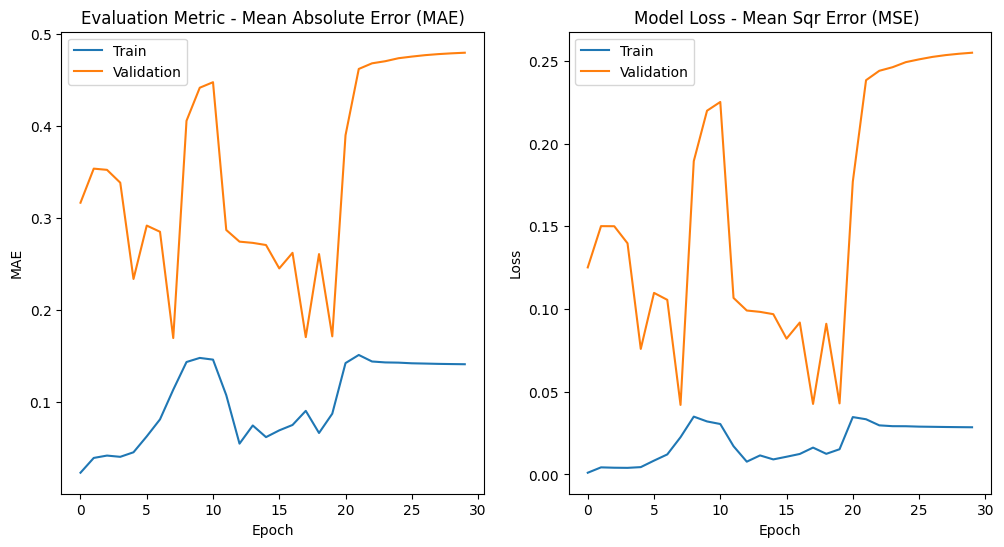

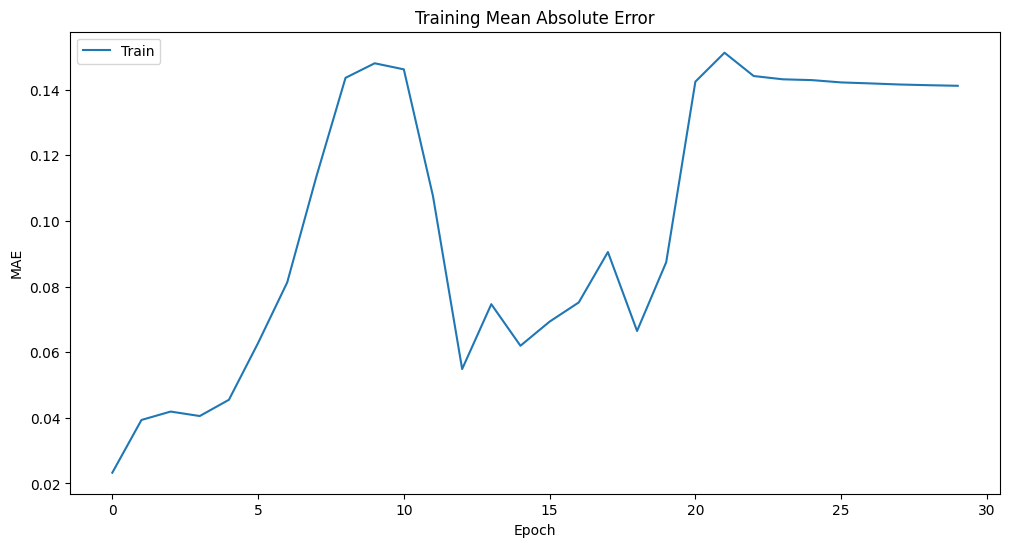

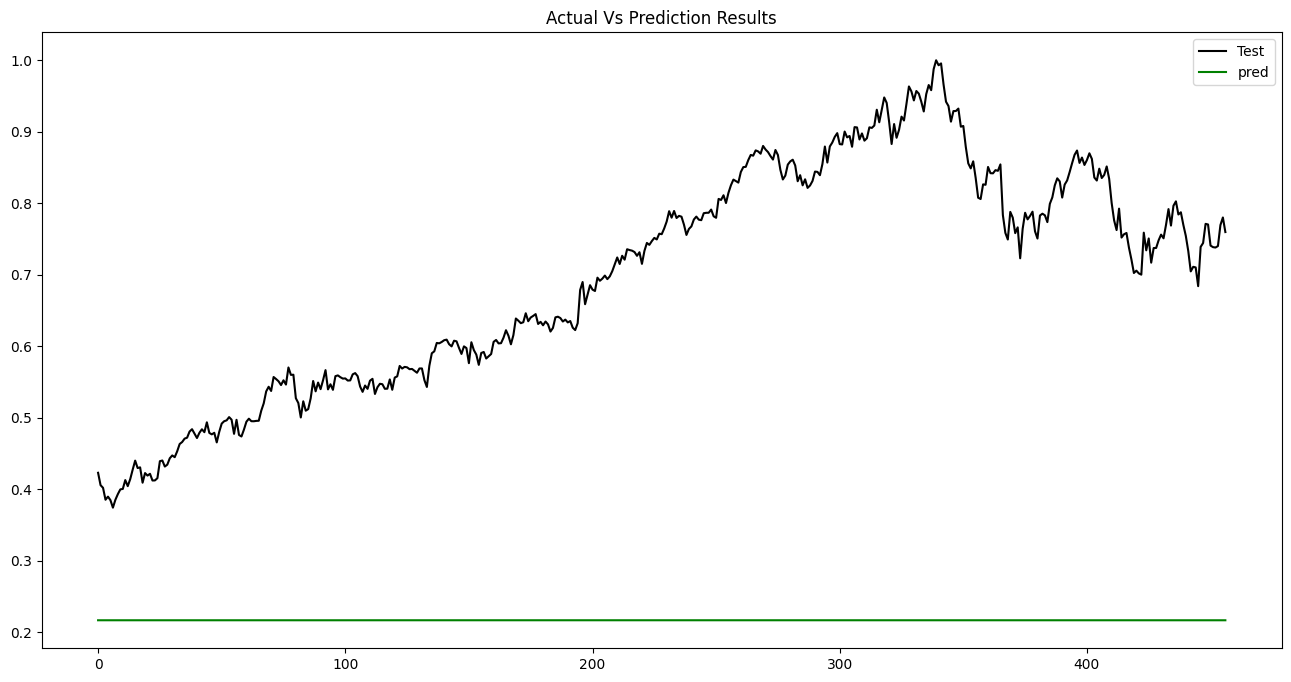

############################################################################
  Model Setup:
                    Name: MSI_F25_L6
             LSTM_Layers: 6
              LSTM_Nodes: 41
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: MSI
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 25
  Result Data:
             mean_abs_err =0.474415379158624
             mean_sqr_err =0.24939904466052074
        root_mean_sqr_err =0.4993986830784806
           pred_diff_mean =0.33914601053470095
      pred_diff_bias_mean =0.6608539894652992
    pred_correctness_mean =0.2422907488986784



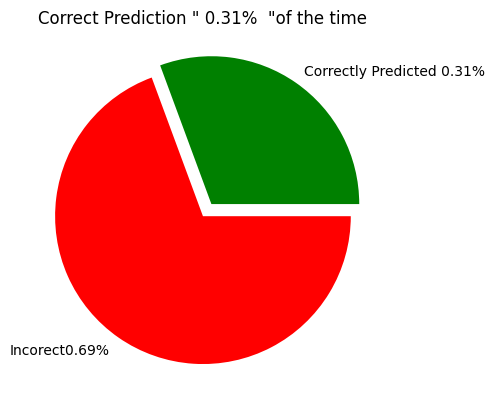

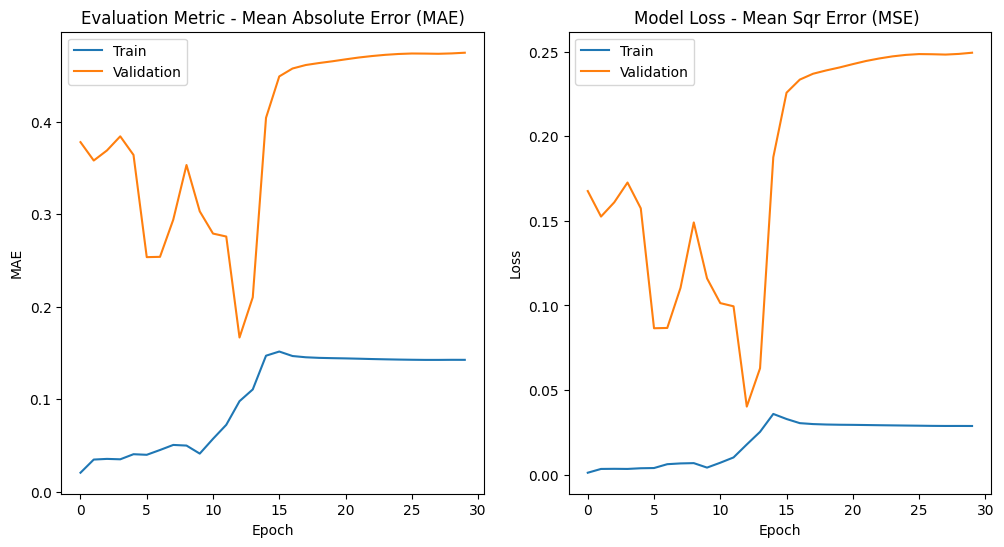

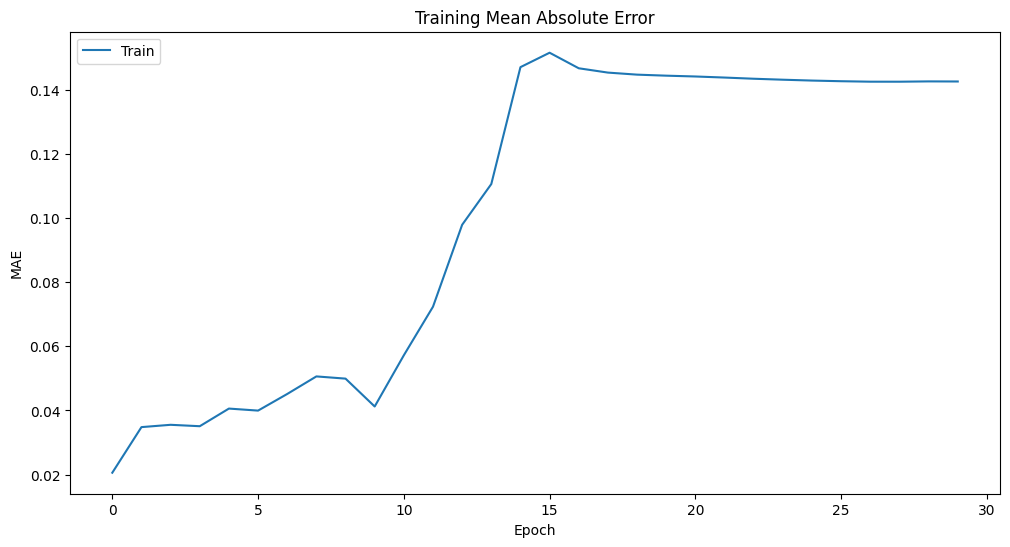

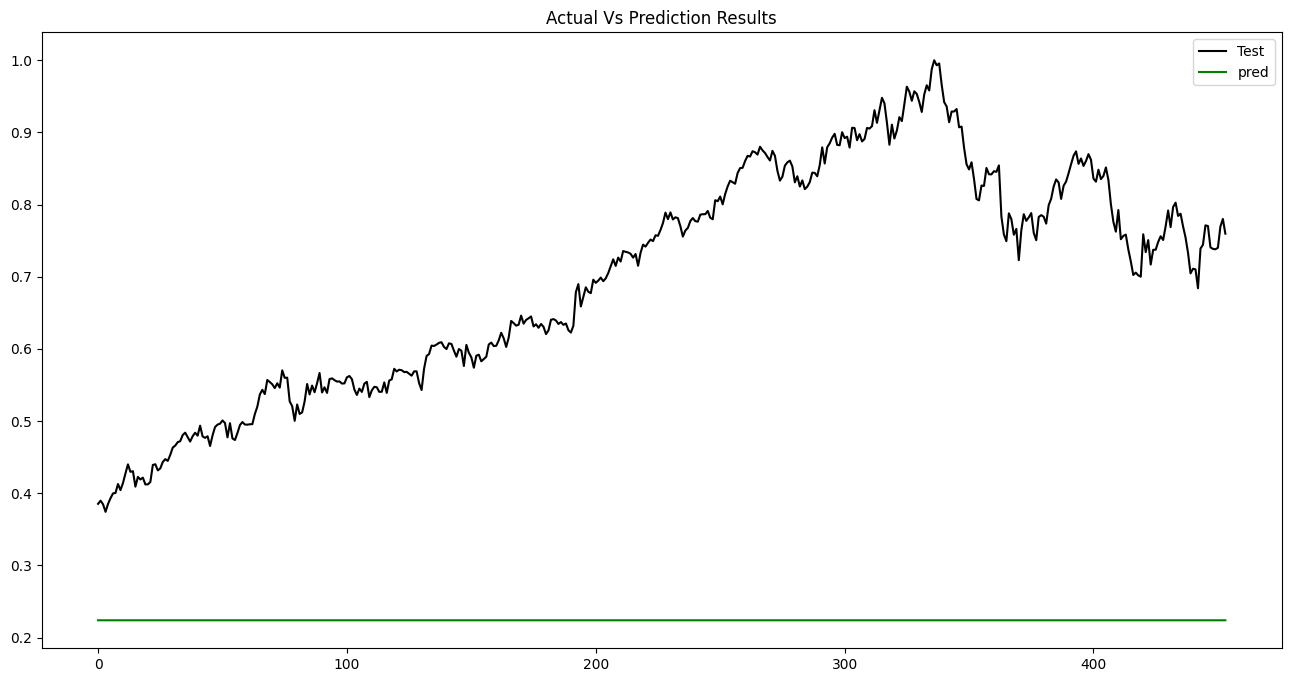

############################################################################
  Model Setup:
                    Name: MSI_F50_L6
             LSTM_Layers: 6
              LSTM_Nodes: 41
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: MSI
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 50
  Result Data:
             mean_abs_err =0.4747631568117318
             mean_sqr_err =0.2488858488555664
        root_mean_sqr_err =0.4988846047490004
           pred_diff_mean =0.34116612592631623
      pred_diff_bias_mean =0.6588338740736838
    pred_correctness_mean =0.22717149220489977



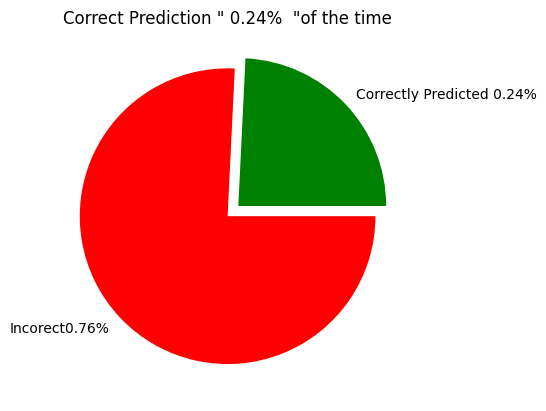

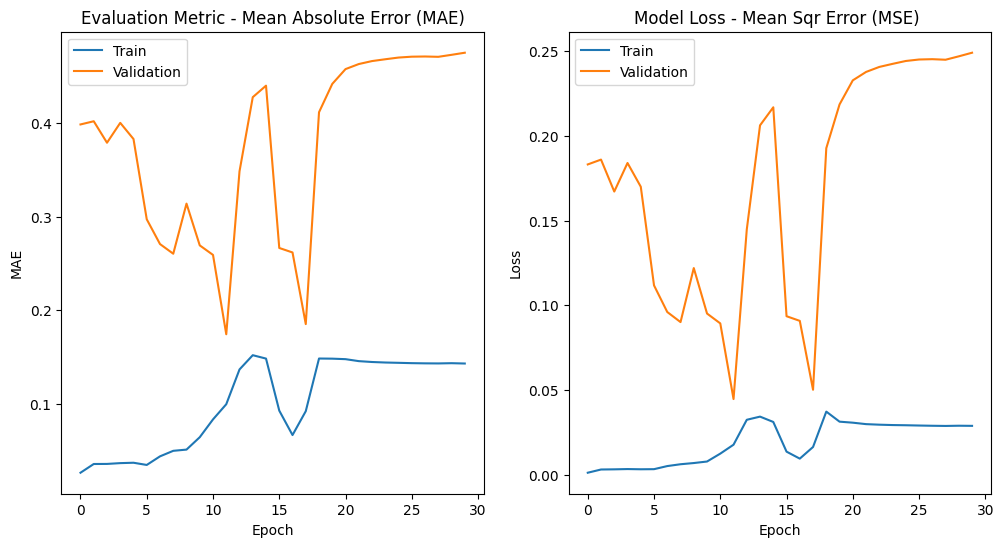

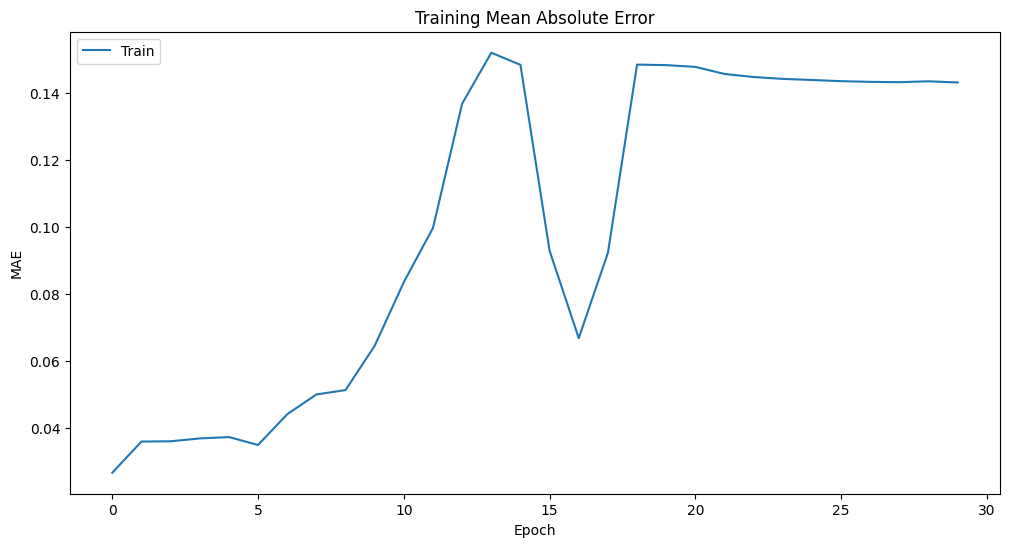

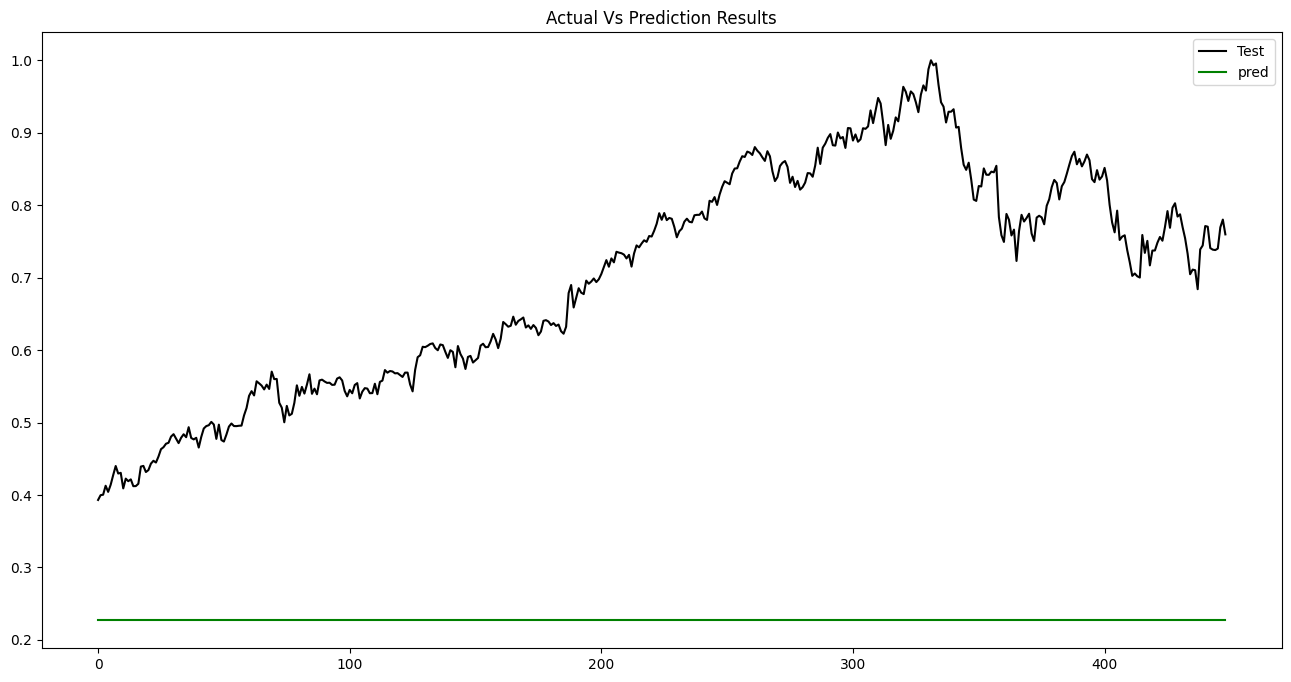

############################################################################
  Model Setup:
                    Name: MSI_F75_L6
             LSTM_Layers: 6
              LSTM_Nodes: 41
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: MSI
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 75
  Result Data:
             mean_abs_err =0.4715007199697108
             mean_sqr_err =0.2450389852715257
        root_mean_sqr_err =0.4950141263353256
           pred_diff_mean =0.3485484894649547
      pred_diff_bias_mean =0.6514515105350454
    pred_correctness_mean =0.23648648648648649



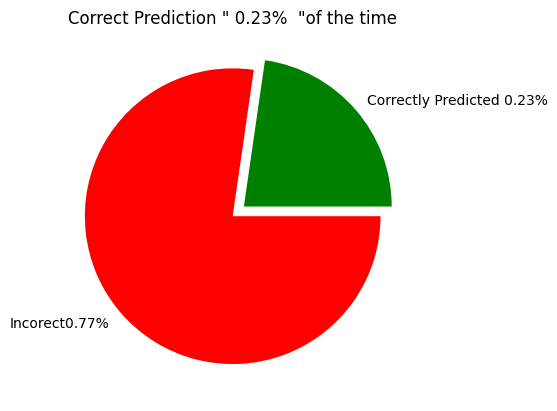

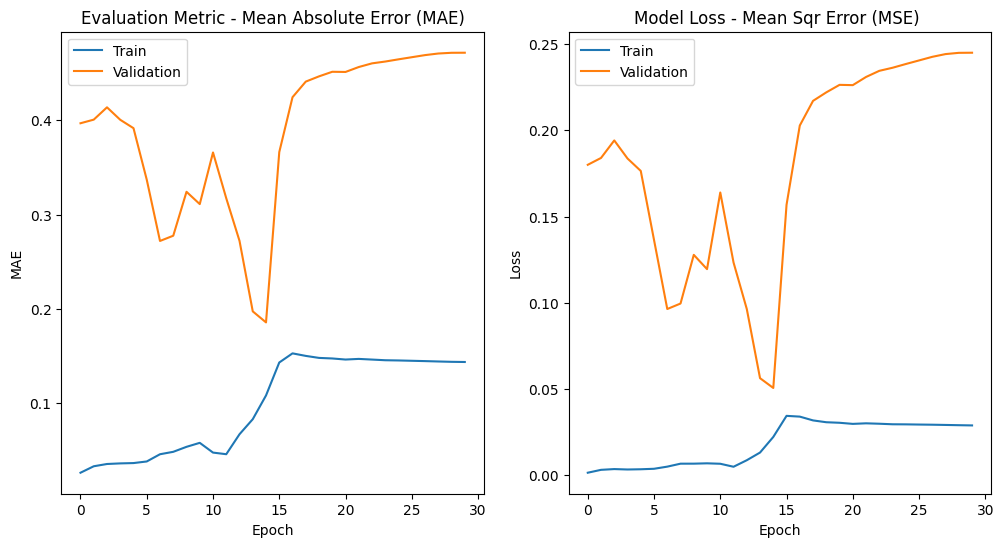

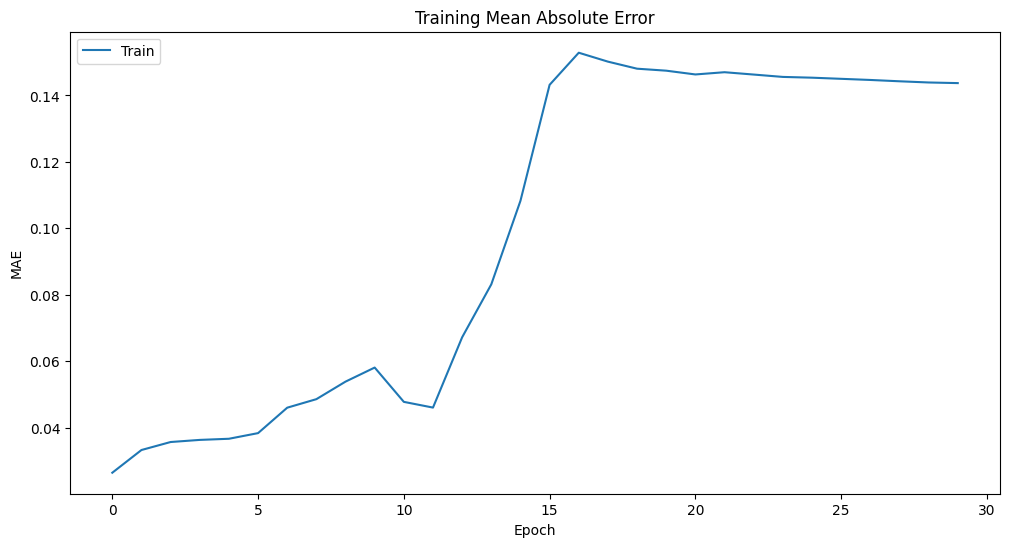

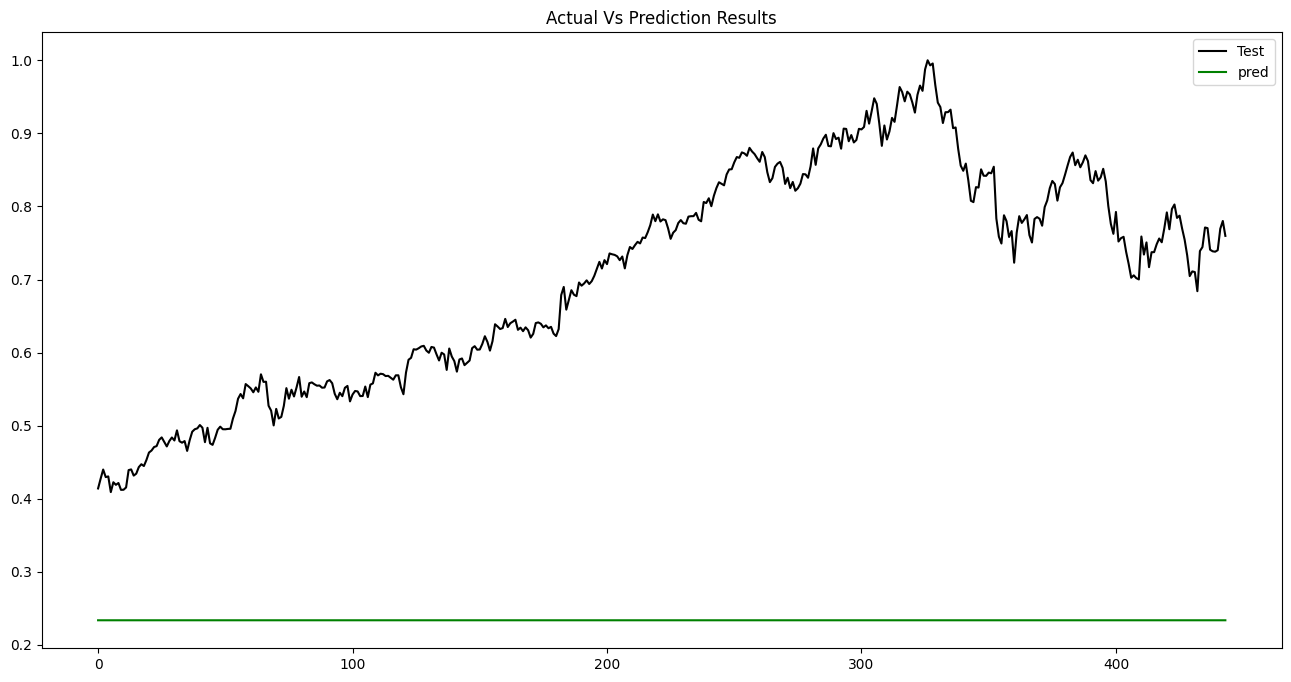

############################################################################
  Model Setup:
                    Name: MSI_F100_L6
             LSTM_Layers: 6
              LSTM_Nodes: 41
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: MSI
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 100
  Result Data:
             mean_abs_err =0.47557373915819323
             mean_sqr_err =0.2482719957717489
        root_mean_sqr_err =0.49826899940870184
           pred_diff_mean =0.3449397905090669
      pred_diff_bias_mean =0.6550602094909331
    pred_correctness_mean =0.2505694760820046



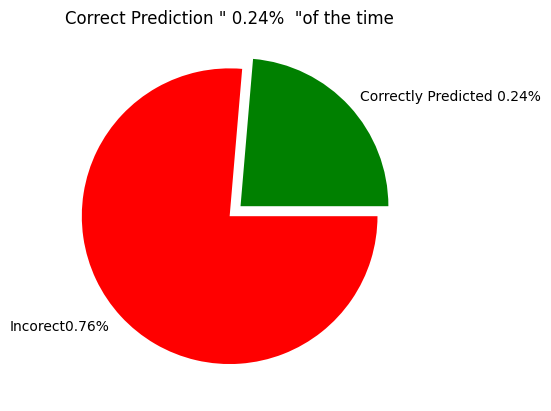

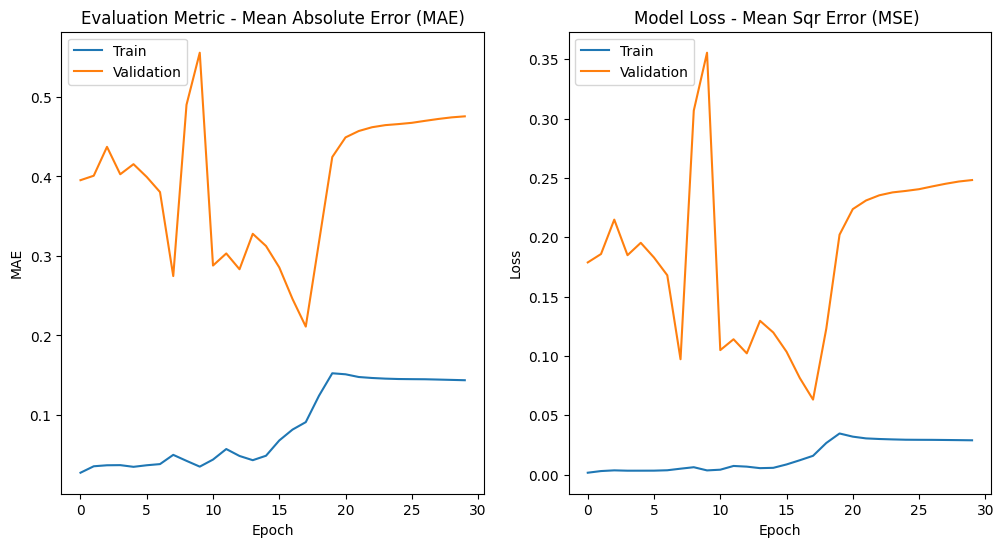

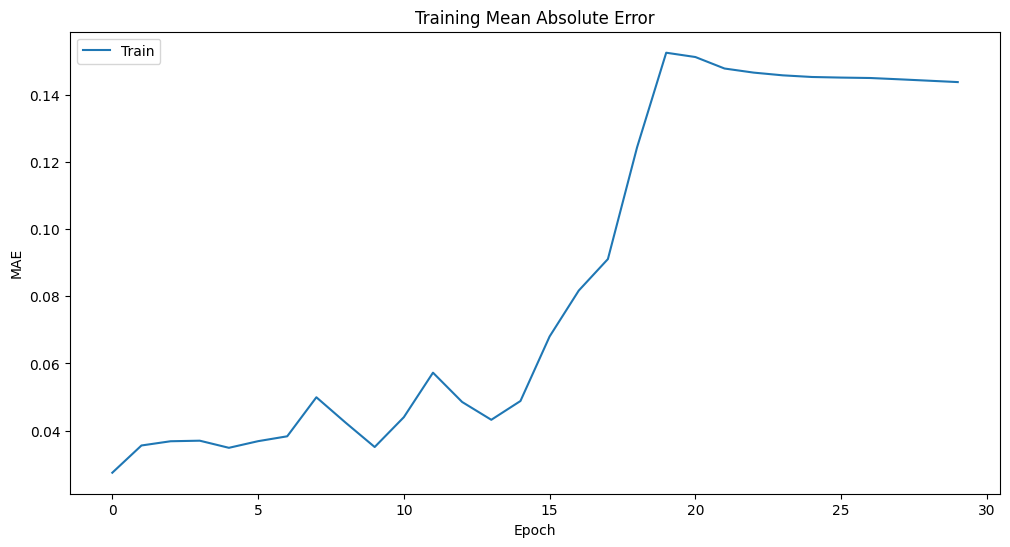

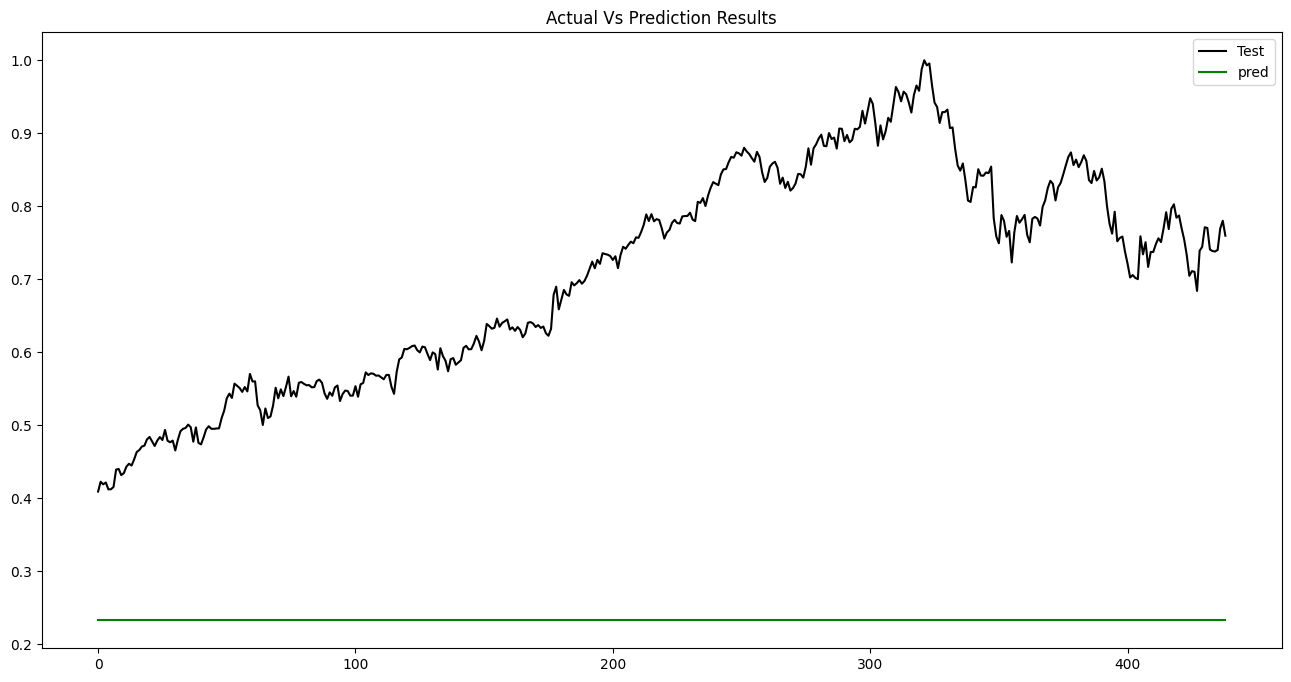

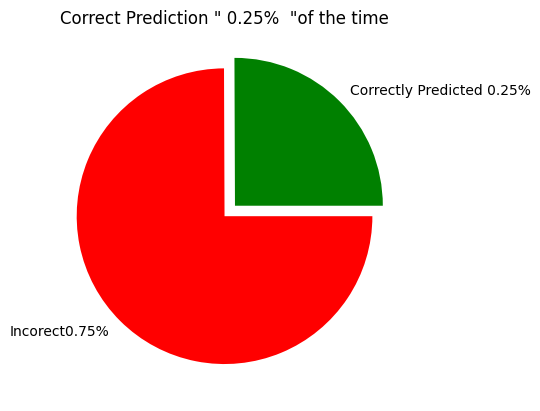

In [10]:
for m in model_list:
  m.View_Performance_Report(show_graphs=True)


#Save Data
##Save Data to Drive

In [11]:
#_ls '/content/drive/MyDrive/Classes/Kent/Machine Learning/Results'

##Save Best Model to drive